### Fitting DataSets to Shallow and Deep Neural Net

#### Easy (Titanic)

Preprocessing

In [1]:
# import all packages
import pandas as pd
import numpy as np
import re
import keras
from keras import models
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [2]:
# Preprossed as suggested here
# https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8

In [3]:
# Load data
titanic = pd.read_csv(r"C:\Users\Axel\Documents\Nova_IMS\2_Semester\Deep Learning\Project\DLProject\data_files\Easy\titanic.csv")

In [4]:
# Drop ticket, home.dest, boat, body
titanic = titanic.drop(['ticket', 'home.dest', 'boat', 'body'], axis=1)

In [5]:
# Deal with cabin missing values
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

titanic['cabin'] = titanic['cabin'].fillna("U0")
titanic['deck'] = titanic['cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
titanic['deck'] = titanic['deck'].map(deck)
titanic['deck'] = titanic['deck'].fillna(0)
titanic['deck'] = titanic['deck'].astype(int)
# we can now drop the cabin feature
titanic = titanic.drop(['cabin'], axis=1)

In [6]:
# Deal with Age missing values
mean = titanic["age"].mean()
std = titanic["age"].std()
is_null = titanic["age"].isnull().sum()
# compute random numbers between the mean, std and is_null
rand_age = np.random.randint(mean - std, mean + std, size = is_null)
# fill NaN values in Age column with random values generated
age_slice = titanic["age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
titanic["age"] = age_slice
titanic["age"] = titanic["age"].astype(int)

In [7]:
# Deal with Embarked missing values
common_value = 'S'
titanic['embarked'] = titanic['embarked'].fillna(common_value)

In [8]:
# Converting Fares
titanic['fare'] = titanic['fare'].fillna(0)
titanic['fare'] = titanic['fare'].astype(int)

In [9]:
# Converting Names
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

# extract titles
titanic['title'] = titanic.name.str.extract(' ([A-Za-z]+)\.', expand=False)
# replace titles with a more common title or as Rare
titanic['title'] = titanic['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic['title'] = titanic['title'].replace('Mlle', 'Miss')
titanic['title'] = titanic['title'].replace('Ms', 'Miss')
titanic['title'] = titanic['title'].replace('Mme', 'Mrs')
# convert titles into numbers
titanic['title'] = titanic['title'].map(titles)
# filling NaN with 0, to get safe
titanic['title'] = titanic['title'].fillna(0)
titanic = titanic.drop(['name'], axis=1)

In [10]:
# Converting Sex
genders = {"male": 0, "female": 1}
titanic['sex'] = titanic['sex'].map(genders)

In [11]:
# Converting Embarked
ports = {"S": 0, "C": 1, "Q": 2}
titanic['embarked'] = titanic['embarked'].map(ports)

In [12]:
# Rearrange columns
titanic = titanic[['pclass', "sex","age","sibsp","parch","fare", "embarked", "deck", "title", "survived"]]

In [14]:
# Encode with one hot encoder
onehotencoder = OneHotEncoder(categorical_features = [0, 3, 4, 7, 8])
titanic = onehotencoder.fit_transform(titanic).toarray()

C:\Users\Axel\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Axel\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [15]:
# back to df after encoding
titanic = pd.DataFrame(titanic)

Split to train and test set

In [17]:
# Create train, test set
y = titanic[36]
X = titanic.drop(36, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
# get validation set
x_val = X_train[:100]
partial_X_train = X_train[100:]
y_val = y_train[:100]
partial_y_train = y_train[100:]

Shallow Neural Net

In [19]:
def keras_shallow(input_dim=39, n_layers=3, n_neurons=6, r_dropout=0.5, optimizer="rmsprop", loss="binary_crossentropy", init="uniform", metrics=["accuracy"], random_state=42):
    """
    shallow neural net, define the amount of layers either having 1 or 2 hidden layers., which optimizer you want to use and which loss function you want to apply.
    """ 
    np.random.seed(random_state)
    

    from keras import backend as K
    K.clear_session()


    model = models.Sequential()
    model.add(layers.Dense(n_neurons, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(r_dropout))
    for num in range(n_layers-2):
        model.add(layers.Dense(n_neurons, activation="relu"))
        model.add(layers.Dropout(r_dropout))
    model.add(layers.Dense(1, activation="sigmoid", init=init))
    model.compile(optimizer, loss, metrics=metrics)
    
    return model

In [20]:
shallow_nn = keras_shallow(input_dim=len(X_train.columns))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


In [21]:
history_shallow = shallow_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 816 samples, validate on 100 samples
Epoch 1/20
816/816 [==============================] - 1s 702us/step - loss: 0.6820 - acc: 0.6017 - val_loss: 0.6817 - val_acc: 0.6800
Epoch 2/20
816/816 [==============================] - 0s 11us/step - loss: 0.6814 - acc: 0.5931 - val_loss: 0.6795 - val_acc: 0.6800
Epoch 3/20
816/816 [==============================] - 0s 10us/step - loss: 0.6709 - acc: 0.6434 - val_loss: 0.6751 - val_acc: 0.6800
Epoch 4/20
816/816 [==============================] - 0s 9us/step - loss: 0.6746 - acc: 0.6091 - val_loss: 0.6725 - val_acc: 0.6700
Epoch 5/20
816/816 [==============================] - 0s 14us/step - loss: 0.6704 - acc: 0.6115 - val_loss: 0.6698 - val_acc: 0.6700
Epoch 6/20
816/816 [==============================] - 0s 10us/step - loss: 0.6693 - acc: 0.6189 - val_loss: 0.6692 - val_acc: 0.6700
Epoch 7/20
816/816 [==============================] - 0s 10us/step - loss: 0.6685 - acc: 0.6348 - val_loss: 

In [22]:
history_dict = history_shallow.history

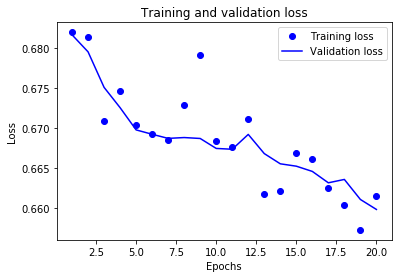

In [23]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

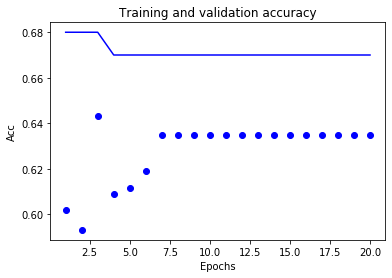

In [24]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

In [25]:
shallow_nn.predict(X_test)

array([[0.43025687],
       [0.47062224],
       [0.4197802 ],
       [0.433561  ],
       [0.43167114],
       [0.44039822],
       [0.4478532 ],
       [0.4491454 ],
       [0.43518052],
       [0.48380664],
       [0.47203586],
       [0.47127277],
       [0.4757119 ],
       [0.4355194 ],
       [0.43376356],
       [0.45326063],
       [0.4213535 ],
       [0.4465282 ],
       [0.47942173],
       [0.46916127],
       [0.45673725],
       [0.42860112],
       [0.454931  ],
       [0.4623077 ],
       [0.4547601 ],
       [0.48573887],
       [0.42628732],
       [0.44571012],
       [0.45326063],
       [0.4764664 ],
       [0.45073277],
       [0.48687553],
       [0.4837736 ],
       [0.48276076],
       [0.48611808],
       [0.44567943],
       [0.48876864],
       [0.44032297],
       [0.48768932],
       [0.48413774],
       [0.4408419 ],
       [0.46004662],
       [0.4233099 ],
       [0.45231143],
       [0.4669488 ],
       [0.43727684],
       [0.43862972],
       [0.462

Deep Neural Network

In [26]:
def keras_deep(input_dim=39, n_layers=9, n_neurons=12, r_dropout=0.5, optimizer="rmsprop", loss="binary_crossentropy", init="uniform", metrics=["accuracy"], random_state=42):
    """
    Keras Neural Network, define the amount of layers you want, which optimizer you want to use and which loss function you want to apply.
    """ 
    np.random.seed(random_state)
    

    from keras import backend as K
    K.clear_session()


    model = models.Sequential()
    model.add(layers.Dense(n_neurons, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(r_dropout))
    for num in range(n_layers-2):
        model.add(layers.Dense(n_neurons, activation="relu"))
        model.add(layers.Dropout(r_dropout))
    model.add(layers.Dense(1, activation="sigmoid", init=init))
    model.compile(optimizer, loss, metrics=metrics)
    
    return model

In [27]:
deep_nn = keras_deep(input_dim=len(X_train.columns))

C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


In [28]:
history_deep = deep_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 816 samples, validate on 100 samples
Epoch 1/20
816/816 [==============================] - 1s 1ms/step - loss: 0.7269 - acc: 0.6078 - val_loss: 0.6919 - val_acc: 0.6700
Epoch 2/20
816/816 [==============================] - 0s 16us/step - loss: 0.6997 - acc: 0.6152 - val_loss: 0.6912 - val_acc: 0.6700
Epoch 3/20
816/816 [==============================] - 0s 18us/step - loss: 0.7098 - acc: 0.6299 - val_loss: 0.6908 - val_acc: 0.6700
Epoch 4/20
816/816 [==============================] - 0s 15us/step - loss: 0.6936 - acc: 0.6103 - val_loss: 0.6903 - val_acc: 0.6700
Epoch 5/20
816/816 [==============================] - 0s 16us/step - loss: 0.6963 - acc: 0.6201 - val_loss: 0.6898 - val_acc: 0.6700
Epoch 6/20
816/816 [==============================] - 0s 15us/step - loss: 0.7001 - acc: 0.6115 - val_loss: 0.6895 - val_acc: 0.6700
Epoch 7/20
816/816 [==============================] - 0s 19us/step - loss: 0.6919 - acc: 0.6299 - val_loss: 0.6890 - val_acc: 0.6700
Epoch 8/20
816/816 [====

In [29]:
history_dict = history_deep.history

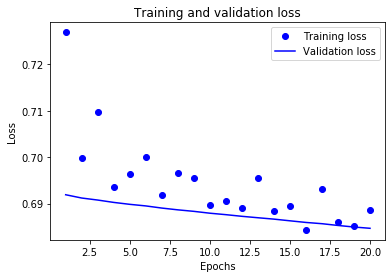

In [30]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

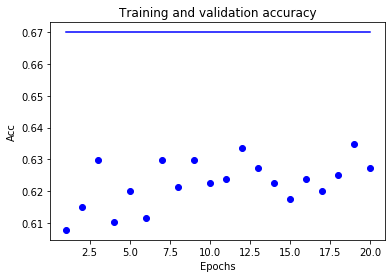

In [31]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

In [32]:
deep_nn.predict(X_test)

array([[0.48707187],
       [0.48683113],
       [0.4870722 ],
       [0.48707318],
       [0.48707196],
       [0.48712385],
       [0.48699403],
       [0.48707557],
       [0.48707184],
       [0.4863956 ],
       [0.48639545],
       [0.48690125],
       [0.48685423],
       [0.48704973],
       [0.48705968],
       [0.4869716 ],
       [0.48707223],
       [0.48698753],
       [0.4863667 ],
       [0.48690563],
       [0.48695758],
       [0.4870446 ],
       [0.48696345],
       [0.48696044],
       [0.48697057],
       [0.4863943 ],
       [0.48711255],
       [0.48701006],
       [0.4869716 ],
       [0.48633844],
       [0.4870735 ],
       [0.48639777],
       [0.48662847],
       [0.4863956 ],
       [0.48640254],
       [0.48703474],
       [0.48641676],
       [0.48711985],
       [0.48642063],
       [0.4863956 ],
       [0.48706493],
       [0.4869588 ],
       [0.48709998],
       [0.4870044 ],
       [0.4869406 ],
       [0.48704118],
       [0.48706588],
       [0.486

Conclusion

Besides normal preprocessing nothing special to do with the data to fit into shallow/deep neural networks.

#### Santander (Big)

Preprocessing

In [33]:
# Load data
santander = pd.read_csv(r"C:\Users\Axel\Documents\Nova_IMS\2_Semester\Deep Learning\Project\DLProject\data_files\Big\santander.csv")

In [34]:
# drop id column
santander = santander.drop(["ID_code"], axis=1)

Split train and test data

In [43]:
# Get train and test set
y = santander.target
X = santander.drop(["target"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
# get validation set
x_val = X_train[:10000]
partial_X_train = X_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Shallow Neural Net

In [45]:
shallow_nn = keras_shallow(input_dim=len(X_train.columns))

C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


In [46]:
history_shallow = shallow_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 130000 samples, validate on 10000 samples
Epoch 1/20
130000/130000 [==============================] - 3s 22us/step - loss: 0.4377 - acc: 0.8983 - val_loss: 0.3725 - val_acc: 0.9033
Epoch 2/20
130000/130000 [==============================] - 2s 19us/step - loss: 0.3822 - acc: 0.9001 - val_loss: 0.3345 - val_acc: 0.9033
Epoch 3/20
130000/130000 [==============================] - 2s 19us/step - loss: 0.3419 - acc: 0.9001 - val_loss: 0.2836 - val_acc: 0.9033
Epoch 4/20
130000/130000 [==============================] - 2s 19us/step - loss: 0.3185 - acc: 0.9001 - val_loss: 0.2878 - val_acc: 0.9033
Epoch 5/20
130000/130000 [==============================] - 3s 19us/step - loss: 0.3064 - acc: 0.9001 - val_loss: 0.2768 - val_acc: 0.9033
Epoch 6/20
130000/130000 [==============================] - 2s 19us/step - loss: 0.3019 - acc: 0.9001 - val_loss: 0.2755 - val_acc: 0.9033
Epoch 7/20
130000/130000 [==============================] - 2s 19us/step - loss: 0.2983 - acc: 0.9001 - val_loss: 0

In [47]:
history_dict = history_shallow.history

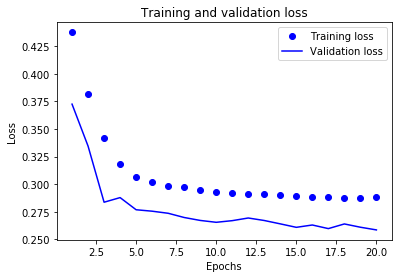

In [48]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

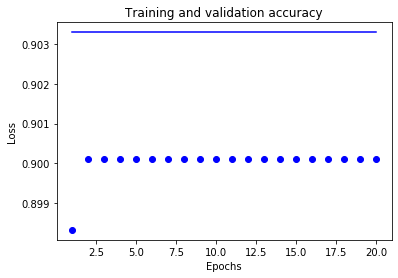

In [49]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [50]:
shallow_nn.predict(X_test)

array([[0.00161359],
       [0.007081  ],
       [0.0094834 ],
       ...,
       [0.1875602 ],
       [0.00115663],
       [0.067332  ]], dtype=float32)

Deep Neural Network

In [51]:
deep_nn = keras_deep(input_dim=len(X_train.columns))

C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


In [52]:
history_deep = deep_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 130000 samples, validate on 10000 samples
Epoch 1/20
130000/130000 [==============================] - 4s 34us/step - loss: 0.5111 - acc: 0.8982 - val_loss: 0.5120 - val_acc: 0.9033
Epoch 2/20
130000/130000 [==============================] - 3s 26us/step - loss: 0.3814 - acc: 0.9001 - val_loss: 0.3235 - val_acc: 0.9033
Epoch 3/20
130000/130000 [==============================] - 3s 26us/step - loss: 0.3418 - acc: 0.9001 - val_loss: 0.3192 - val_acc: 0.9033
Epoch 4/20
130000/130000 [==============================] - 3s 26us/step - loss: 0.3356 - acc: 0.9001 - val_loss: 0.3183 - val_acc: 0.9033
Epoch 5/20
130000/130000 [==============================] - 3s 26us/step - loss: 0.3314 - acc: 0.9001 - val_loss: 0.3198 - val_acc: 0.9033
Epoch 6/20
130000/130000 [==============================] - 3s 26us/step - loss: 0.3289 - acc: 0.9001 - val_loss: 0.3202 - val_acc: 0.9033
Epoch 7/20
130000/130000 [==============================] - 3s 26us/step - loss: 0.3258 - acc: 0.9001 - val_loss: 0

In [53]:
history_dict = history_deep.history

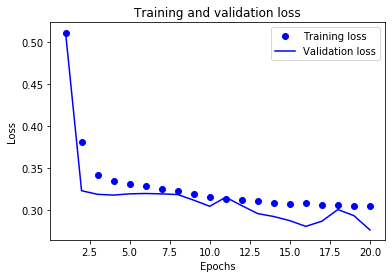

In [54]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

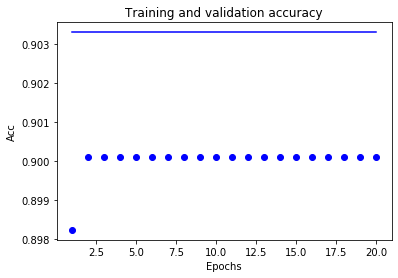

In [55]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

In [56]:
deep_nn.predict(X_test)

array([[0.00234276],
       [0.00690815],
       [0.01746318],
       ...,
       [0.15288481],
       [0.00083536],
       [0.06288835]], dtype=float32)

Conclusion

Besides dropping the ID column, no further preprocessing/things to consider before passing to shallow/deep neural network.

#### Weather Australia (Time Series)

Preprocessing

In [59]:
weather = pd.read_csv(r"C:\Users\Axel\Documents\Nova_IMS\2_Semester\Deep Learning\Project\DLProject\data_files\TimeSeries\weatherAUS.csv")

In [60]:
weather.isna().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

In [61]:
# drop columns with too many missing values, Location & Wind Directions as well (to not produce so many new columns when encoding)
weather = weather.drop(["Evaporation","Sunshine","Cloud9am","Cloud3pm","WindGustDir","WindDir9am", "Location", 'WindDir3pm'], axis=1)

In [62]:
# Get binary variables to 1 and 0
weather['RainTomorrow'] = weather['RainTomorrow'].map({'Yes': 1, 'No': 0})
weather['RainToday'] = weather['RainToday'].map({'Yes': 1, 'No': 0})

In [63]:
# impute missing values
weather["Temp3pm"] = weather["Temp3pm"].fillna(weather["Temp3pm"].mean())
weather["Pressure3pm"] = weather["Pressure3pm"].fillna(weather["Pressure3pm"].mean())
weather["Temp9am"] = weather["Temp9am"].fillna(weather["Temp9am"].mean())
weather["Pressure9am"] = weather["Pressure3pm"].fillna(weather["Pressure3pm"].mean())
weather["Humidity9am"] = weather["Humidity9am"].fillna(weather["Humidity9am"].mean())
weather["Humidity3pm"] = weather["Humidity3pm"].fillna(weather["Humidity3pm"].mean())
weather["MinTemp"] = weather["MinTemp"].fillna(weather["MinTemp"].mean())
weather["MaxTemp"] = weather["MaxTemp"].fillna(weather["MaxTemp"].mean())
weather["WindGustSpeed"] = weather["WindGustSpeed"].fillna(weather["WindGustSpeed"].mean())
weather["WindSpeed9am"] = weather["WindSpeed9am"].fillna(weather["WindSpeed9am"].mean())
weather["WindSpeed3pm"] = weather["WindSpeed3pm"].fillna(weather["WindSpeed3pm"].mean())

In [64]:
# check for missing values again
weather.isna().sum()

Date                0
MinTemp             0
MaxTemp             0
Rainfall         1406
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Temp9am             0
Temp3pm             0
RainToday        1406
RISK_MM             0
RainTomorrow        0
dtype: int64

In [67]:
# drop rest of the rows (e.g. rainfall should only be there if rain today is a 1. Would require kind of dependent imputation)
weather = weather[pd.notnull(weather['RainToday'])]
weather = weather[pd.notnull(weather['Rainfall'])]

In [68]:
weather.isna().sum()

Date             0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RISK_MM          0
RainTomorrow     0
dtype: int64

In [69]:
# convert date to datetime
weather["Date"] = pd.to_datetime(weather["Date"])

In [70]:
# convert date to days since start date (measures distance between minimum date)
# This way at least some information of time can be kept, even though it might not be the perfect solution
# Got this idea from here:
# https://stackoverflow.com/questions/42044003/how-to-use-date-and-time-values-as-features-to-predict-a-value-using-a-neural-ne

start = min(weather["Date"])
date_features = [(i - start) for i in weather["Date"]]
date_features = [i.days for i in date_features]

In [71]:
# Replace date with days
weather["Date"] = date_features

Split into Train and Test Set

In [73]:
# Get train and test set
y = weather.RainTomorrow
X = weather.drop(["RainTomorrow"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [74]:
# get validation set
x_val = X_train[:10000]
partial_X_train = X_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Shallow Neural Network

In [75]:
shallow_nn = keras_shallow(input_dim=len(X_train.columns))

C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


In [76]:
history_shallow = shallow_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 88550 samples, validate on 10000 samples
Epoch 1/20
88550/88550 [==============================] - 1s 11us/step - loss: 0.6893 - acc: 0.7637 - val_loss: 0.5671 - val_acc: 0.7777
Epoch 2/20
88550/88550 [==============================] - 1s 6us/step - loss: 0.5969 - acc: 0.7754 - val_loss: 0.5704 - val_acc: 0.7777
Epoch 3/20
88550/88550 [==============================] - 1s 6us/step - loss: 0.5688 - acc: 0.7784 - val_loss: 0.5505 - val_acc: 0.7777
Epoch 4/20
88550/88550 [==============================] - 1s 6us/step - loss: 0.5338 - acc: 0.7791 - val_loss: 0.4788 - val_acc: 0.7777
Epoch 5/20
88550/88550 [==============================] - 1s 6us/step - loss: 0.5038 - acc: 0.7791 - val_loss: 0.4777 - val_acc: 0.7777
Epoch 6/20
88550/88550 [==============================] - 1s 6us/step - loss: 0.4970 - acc: 0.7791 - val_loss: 0.4412 - val_acc: 0.7777
Epoch 7/20
88550/88550 [==============================] - 1s 6us/step - loss: 0.4943 - acc: 0.7791 - val_loss: 0.4438 - val_acc: 0.77

In [77]:
history_dict = history_shallow.history

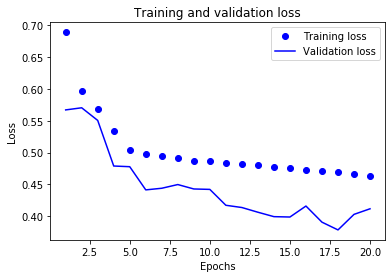

In [78]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

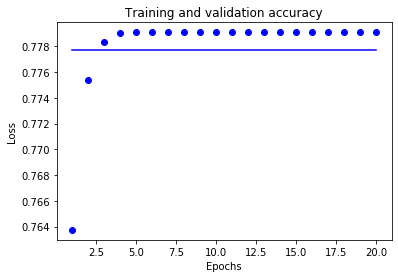

In [79]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [80]:
shallow_nn.predict(X_test)

array([[0.11426151],
       [0.3122403 ],
       [0.09040269],
       ...,
       [0.10935911],
       [0.31224027],
       [0.21289928]], dtype=float32)

Deep Neural Network

In [81]:
deep_nn = keras_deep(input_dim=len(X_train.columns))

C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


In [82]:
history_deep = deep_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 88550 samples, validate on 10000 samples
Epoch 1/20
88550/88550 [==============================] - 2s 24us/step - loss: 0.6998 - acc: 0.7681 - val_loss: 0.6418 - val_acc: 0.7777
Epoch 2/20
88550/88550 [==============================] - 1s 13us/step - loss: 0.6048 - acc: 0.7784 - val_loss: 0.6082 - val_acc: 0.7777
Epoch 3/20
88550/88550 [==============================] - 1s 13us/step - loss: 0.5778 - acc: 0.7790 - val_loss: 0.5802 - val_acc: 0.7777
Epoch 4/20
88550/88550 [==============================] - 1s 13us/step - loss: 0.5570 - acc: 0.7791 - val_loss: 0.5574 - val_acc: 0.7777
Epoch 5/20
88550/88550 [==============================] - 1s 13us/step - loss: 0.5430 - acc: 0.7791 - val_loss: 0.5429 - val_acc: 0.7777
Epoch 6/20
88550/88550 [==============================] - 1s 13us/step - loss: 0.5324 - acc: 0.7791 - val_loss: 0.5333 - val_acc: 0.7777
Epoch 7/20
88550/88550 [==============================] - 1s 13us/step - loss: 0.5235 - acc: 0.7791 - val_loss: 0.5307 - val_acc

In [83]:
history_dict = history_deep.history

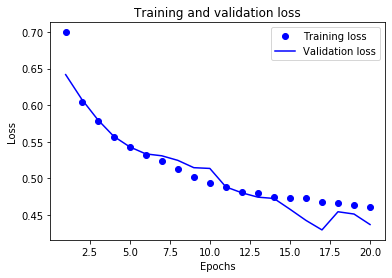

In [84]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

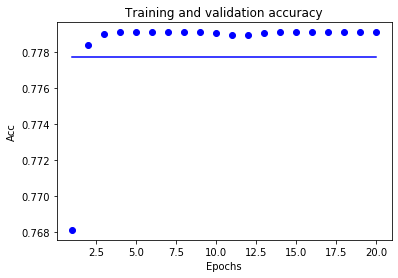

In [85]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

In [86]:
deep_nn.predict(X_test)

array([[0.12323707],
       [0.355599  ],
       [0.09223631],
       ...,
       [0.15396634],
       [0.35559896],
       [0.24343115]], dtype=float32)

#### Cactus (Image)

Preprocessing

In [216]:
train_dir = r'C:\Users\Axel\Documents\Nova_IMS\2_Semester\Deep Learning\Project\DLProject\data_files\Cactus_Image\training_set'
test_dir = r"C:\Users\Axel\Documents\Nova_IMS\2_Semester\Deep Learning\Project\DLProject\data_files\Cactus_Image\testing_set"

In [217]:
from keras.preprocessing.image import ImageDataGenerator
# define directory
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [218]:
# get train images
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),
        batch_size=20,
        class_mode="binary")

Found 13999 images belonging to 2 classes.


In [219]:
# get test images
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        batch_size=20,
        class_mode="binary")

Found 3501 images belonging to 2 classes.


In [238]:
# limit m is choosen for testing reasons, computation over all images takes 1000 years and is problematic due
# to the fact that 13999 can not be divided by the batch size of 20. did not know how to access that somehow else
limit_train=5
limit_test=2
# get dataframe with flattend train images corresponding to size 64x64x3
images_train = pd.DataFrame()
m = 0
for i in train_generator:
    n=0
    m = m+1
    if m == limit_train:
        break
    else:
        while n <= 19:
            a = i[0][n].flatten()
            print(a)
            n = n+1
            b= pd.DataFrame(a)
            b=b.transpose()
            images_train=images_train.append(b)

[0.37254903 0.3529412  0.3803922  ... 0.6117647  0.5254902  0.5764706 ]
[0.5058824  0.4156863  0.43921572 ... 0.34901962 0.35686275 0.30588236]
[0.67058825 0.627451   0.6431373  ... 0.5647059  0.5764706  0.54901963]
[0.6        0.5294118  0.52156866 ... 0.57254905 0.50980395 0.5137255 ]
[0.78823537 0.7058824  0.7725491  ... 0.59607846 0.4784314  0.50980395]
[0.6117647  0.5568628  0.52156866 ... 0.52156866 0.5372549  0.47058827]
[0.6745098  0.62352943 0.5921569  ... 0.6666667  0.6117647  0.6117647 ]
[0.72156864 0.627451   0.6784314  ... 0.70980394 0.5803922  0.654902  ]
[0.5647059  0.54509807 0.57254905 ... 0.5803922  0.52156866 0.59607846]
[0.37647063 0.28235295 0.36862746 ... 0.45882356 0.4156863  0.43921572]
[0.5411765  0.48235297 0.5019608  ... 0.7803922  0.72156864 0.73333335]
[0.627451   0.5372549  0.56078434 ... 0.74509805 0.63529414 0.6901961 ]
[0.22352943 0.24313727 0.21568629 ... 0.3254902  0.32941177 0.30588236]
[0.6117647  0.5921569  0.5803922  ... 0.3921569  0.34509805 0.38

In [241]:
# get dataframe with flattend train images corresponding to size 64x64x3
# also smaller sample
m = 0
for i in test_generator:
    n=0
    m = m+1
    if m == limit_test:
        break
    else:
        while n <= 19:
            a = i[0][n].flatten()
            print(a)
            n = n+1
            b= pd.DataFrame(a)
            b=b.transpose()
            images_test=images_test.append(b)

[0.4039216  0.3803922  0.3803922  ... 0.31764707 0.27058825 0.2784314 ]
[0.36862746 0.3803922  0.3137255  ... 0.43529415 0.45882356 0.41960788]
[0.7372549  0.6666667  0.72156864 ... 0.65882355 0.50980395 0.5921569 ]
[0.5921569  0.49803925 0.56078434 ... 0.62352943 0.5411765  0.5686275 ]
[0.45882356 0.4039216  0.40000004 ... 0.38823533 0.3372549  0.30588236]
[0.43529415 0.38823533 0.34117648 ... 0.4431373  0.39607847 0.34117648]
[0.627451   0.49803925 0.57254905 ... 0.3921569  0.29411766 0.36862746]
[0.3019608  0.27450982 0.3019608  ... 0.5372549  0.4784314  0.5058824 ]
[0.5411765  0.48235297 0.46274513 ... 0.5803922  0.52156866 0.49411768]
[0.38431376 0.32156864 0.36078432 ... 0.43137258 0.32941177 0.3803922 ]
[0.454902   0.5176471  0.4039216  ... 0.57254905 0.5254902  0.53333336]
[0.31764707 0.2627451  0.32941177 ... 0.56078434 0.48235297 0.5254902 ]
[0.4666667  0.47450984 0.3921569  ... 0.47058827 0.454902   0.45882356]
[0.31764707 0.29803923 0.28627452 ... 0.29803923 0.28235295 0.24

In [239]:
# get train target (same m as in image data)
target_train = []
m=0
for i in train_generator:
    m = m+1
    if m==limit_train:
        break
    else:
        c = i[1].tolist()
        target_train = target_train + c

In [242]:
# get train target (same m as in image data)
target_test = []
m=0
for i in test_generator:
    m = m+1
    if m==limit_test:
        break
    else:
        c = i[1].tolist()
        target_test = target_test + c

Split to train and test set

In [243]:
X_train, X_test, y_train, y_test = images_train, images_test, target_train, target_test

In [244]:
# get validation set
x_val = X_train[:10]
partial_X_train = X_train[10:]
y_val = y_train[:10]
partial_y_train = y_train[10:]

Shallow Neural Network

In [245]:
shallow_nn = keras_shallow(input_dim=len(X_train.columns))

C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


In [246]:
history_shallow = shallow_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 70 samples, validate on 10 samples
Epoch 1/20
70/70 [==============================] - 0s 7ms/step - loss: 0.6917 - acc: 0.6143 - val_loss: 0.6273 - val_acc: 0.9000
Epoch 2/20
70/70 [==============================] - 0s 371us/step - loss: 0.6820 - acc: 0.7286 - val_loss: 0.6022 - val_acc: 0.9000
Epoch 3/20
70/70 [==============================] - 0s 357us/step - loss: 0.6744 - acc: 0.6857 - val_loss: 0.6180 - val_acc: 0.9000
Epoch 4/20
70/70 [==============================] - 0s 542us/step - loss: 0.6837 - acc: 0.6714 - val_loss: 0.6370 - val_acc: 0.9000
Epoch 5/20
70/70 [==============================] - 0s 342us/step - loss: 0.6449 - acc: 0.7429 - val_loss: 0.5089 - val_acc: 0.9000
Epoch 6/20
70/70 [==============================] - 0s 357us/step - loss: 0.7119 - acc: 0.6714 - val_loss: 0.5513 - val_acc: 0.9000
Epoch 7/20
70/70 [==============================] - 0s 457us/step - loss: 0.5978 - acc: 0.7429 - val_loss: 0.5214 - val_acc: 0.9000
Epoch 8/20
70/70 [================

In [247]:
history_dict = history_shallow.history

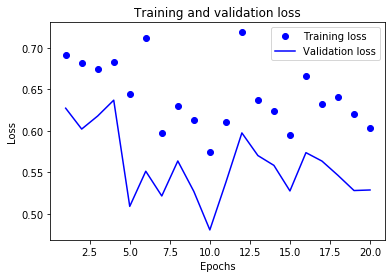

In [248]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

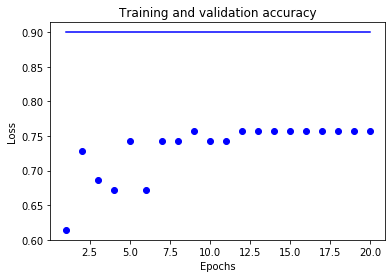

In [249]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [250]:
shallow_nn.predict(X_test)

array([[0.39056665],
       [0.4177832 ],
       [0.36265078],
       [0.36451212],
       [0.4196863 ],
       [0.4064532 ],
       [0.37121165],
       [0.40971893],
       [0.38383183],
       [0.3902996 ],
       [0.37482867],
       [0.37981516],
       [0.39073288],
       [0.41467437],
       [0.40569928],
       [0.43577203],
       [0.35728788],
       [0.38076553],
       [0.40826604],
       [0.38444626]], dtype=float32)

Deep Neural Network

In [251]:
deep_nn = keras_deep(input_dim=len(X_train.columns))

C:\Users\Axel\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`


In [252]:
history_deep = deep_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 70 samples, validate on 10 samples
Epoch 1/20
70/70 [==============================] - 1s 11ms/step - loss: 0.6902 - acc: 0.7143 - val_loss: 0.6814 - val_acc: 0.9000
Epoch 2/20
70/70 [==============================] - 0s 357us/step - loss: 0.6846 - acc: 0.7714 - val_loss: 0.6881 - val_acc: 0.9000
Epoch 3/20
70/70 [==============================] - 0s 314us/step - loss: 0.6811 - acc: 0.7286 - val_loss: 0.6874 - val_acc: 0.9000
Epoch 4/20
70/70 [==============================] - 0s 443us/step - loss: 0.6596 - acc: 0.7286 - val_loss: 0.6842 - val_acc: 0.9000
Epoch 5/20
70/70 [==============================] - 0s 300us/step - loss: 0.6627 - acc: 0.7714 - val_loss: 0.6838 - val_acc: 0.9000
Epoch 6/20
70/70 [==============================] - 0s 429us/step - loss: 0.6155 - acc: 0.7286 - val_loss: 0.6764 - val_acc: 0.9000
Epoch 7/20
70/70 [==============================] - 0s 414us/step - loss: 0.6922 - acc: 0.6714 - val_loss: 0.6763 - val_acc: 0.9000
Epoch 8/20
70/70 [===============

In [253]:
history_dict = history_deep.history

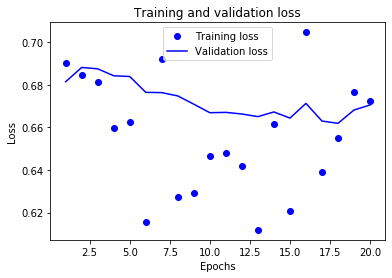

In [254]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

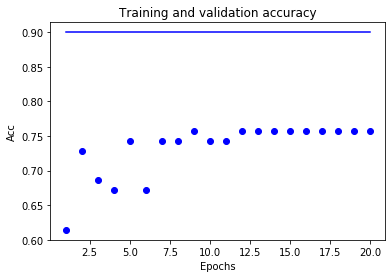

In [255]:
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

In [256]:
deep_nn.predict(X_test)

array([[0.48625016],
       [0.4873419 ],
       [0.4848935 ],
       [0.48488778],
       [0.48732808],
       [0.48684126],
       [0.48522782],
       [0.48702082],
       [0.48595953],
       [0.4861002 ],
       [0.48536786],
       [0.48571938],
       [0.48608974],
       [0.487329  ],
       [0.48680988],
       [0.48818168],
       [0.48461142],
       [0.48563612],
       [0.48693717],
       [0.48580295]], dtype=float32)

#### IMDB (Text)

Preprocessing and Split to Train and Test

In [263]:
import codecs
import nltk
pos_lines_imdb = codecs.open(r"C:\Users\Axel\Documents\Nova_IMS\2_Semester\Deep Learning\Project\DLProject\data_files\Text\positive.txt","r",encoding="latin2").read()
neg_lines_imdb = codecs.open(r"C:\Users\Axel\Documents\Nova_IMS\2_Semester\Deep Learning\Project\DLProject\data_files\Text\negative.txt","r", encoding="latin2").read()
    
all_words_imdb = []
documents_imdb = []
    
allowed_word_types = ["J"]
    
for p in pos_lines_imdb.split("\n"):
    documents_imdb.append((p,"pos"))
    words = word_tokenize(p)
    pos = nltk.pos_tag(words)
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words_imdb.append(w[0].lower())
    
for p in neg_lines_imdb.split("\n"):
    documents_imdb.append((p,"neg"))
    words = word_tokenize(p)
    pos = nltk.pos_tag(words)
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words_imdb.append(w[0].lower())
                
# Get list of lists in dataframe
headers = ["text", "y"]
df = pd.DataFrame(documents_imdb, columns=headers)
df["y"] = df["y"].map({"pos": 1, "neg": 0})

In [265]:
# get frequency of words
from nltk import FreqDist
frequency = FreqDist(all_words_imdb)

In [266]:
# create frequency dataframe
df_imdb = pd.DataFrame.from_dict(frequency, orient='index')
df_imdb = df_alice.rename(columns={0: 'Count'})

In [268]:
# sort values by frequency
df_imdb = df_imdb.sort_values(by=['Count'], ascending=False)

In [269]:
# assign number
df_imdb['Number'] = range(1, 1+len(df_imdb))

In [270]:
df_imdb = df_imdb.reset_index()

In [271]:
df_imdb = df_imdb.rename(columns={"index":"word"})

In [273]:
df_imdb.head()

,word,Count,Number
0,good,369,1
1,more,331,2
2,little,265,3
3,funny,245,4
4,bad,234,5


In [308]:
df = df.loc[1:5]

In [299]:
dictionary = dict(zip(df_imdb.word, df_imdb.Number))

In [311]:
dictionary

{'good': 1,
 'more': 2,
 'little': 3,
 'funny': 4,
 'bad': 5,
 'much': 6,
 'best': 7,
 'new': 8,
 'own': 9,
 'many': 10,
 'most': 11,
 'other': 12,
 'great': 13,
 'big': 14,
 'few': 15,
 'first': 16,
 'real': 17,
 'i': 18,
 'better': 19,
 'full': 20,
 'such': 21,
 'romantic': 22,
 'american': 23,
 'old': 24,
 'same': 25,
 'original': 26,
 'human': 27,
 'hard': 28,
 'interesting': 29,
 '[': 30,
 'young': 31,
 'enough': 32,
 'emotional': 33,
 'least': 34,
 'long': 35,
 'last': 36,
 'cinematic': 37,
 'entertaining': 38,
 'true': 39,
 'high': 40,
 'predictable': 41,
 'special': 42,
 ']': 43,
 'visual': 44,
 'familiar': 45,
 'whole': 46,
 'comic': 47,
 'enjoyable': 48,
 'less': 49,
 'sweet': 50,
 'narrative': 51,
 'short': 52,
 'worst': 53,
 'strong': 54,
 'only': 55,
 'fascinating': 56,
 'obvious': 57,
 'solid': 58,
 'modern': 59,
 'powerful': 60,
 'french': 61,
 'right': 62,
 'fresh': 63,
 'rare': 64,
 'easy': 65,
 'recent': 66,
 'dramatic': 67,
 'next': 68,
 'dull': 69,
 'fine': 70,
 'wo

In [306]:
def find_replace(string, dictonary):
    for item in string:
        for item in dictionary.keys():
            string = string.replace(item, dictionary[item])
    return string

In [309]:
for i in df:
    text = df.text
    new = find_replace(text, word_dict)
    df["numbers"] = new

In [310]:
df.head()

,text,y,tokens,numbers
1,"the gorgeously elaborate continuation of "" the...",1,"[the, gorgeously, elaborate, continuation, of,...","the gorgeously elaborate continuation of "" the..."
2,effective but too-tepid biopic,1,"[effective, but, too-tepid, biopic]",effective but too-tepid biopic
3,if you sometimes like to go to the movies to h...,1,"[if, you, sometimes, like, to, go, to, the, mo...",if you sometimes like to go to the movies to h...
4,"emerges as something rare , an issue movie tha...",1,"[emerges, as, something, rare, ,, an, issue, m...","emerges as something rare , an issue movie tha..."
5,the film provides some great insight into the ...,1,"[the, film, provides, some, great, insight, in...",the film provides some great insight into the ...


In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    results=np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

In [ ]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

Shallow Neural Network

In [ ]:
shallow_nn = keras_shallow(input_dim=len(X_train.columns))

In [ ]:
history_shallow = shallow_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

In [ ]:
history_dict = history_shallow.history

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
shallow_nn.predict(X_test)

Deep Neural Network

In [ ]:
deep_nn = keras_deep(input_dim=len(X_train.columns))

In [ ]:
history_deep = deep_nn.fit(partial_X_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

In [ ]:
history_dict = history_deep.history

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

In [ ]:
deep_nn.predict(X_test)